# Deep mutational scanning of ZIKV NS2B/NS3 protease

*Mutagenized libraries are based on the Zika virus African-lineage MR766 strain split in three 'tiles' over the genome.*

In [2]:
import os
import glob
import Bio.SeqIO
import pandas as pd
from plotnine import *

import dms_tools2
import dms_tools2.prefs
import dms_tools2.utils
from dms_tools2 import AAS
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as CBPALETTE
print(f"Using dms_tools2 {dms_tools2.__version__}")

from IPython.display import display, HTML
from pdf2image import convert_from_path
def showPDF(pdf_path, page_number=0):
    images = convert_from_path(pdf_path, dpi=300, first_page=page_number+1, last_page=page_number+1)
    image = images[0]
    display(image)

Using dms_tools2 2.6.10


Run notebook from `snakemake`. Initialize parameters from the pipeline.

In [3]:
ncpus = snakemake.threads
refseqfile = snakemake.input.amplicon
samplelist = snakemake.input.samplelist
alignspecsfile = snakemake.input.alignspecs
resultsdir = snakemake.output.resultsdir
errpre = snakemake.params.errpre
site_number_offset = snakemake.params.site_number_offset
use_existing = 'no'

print(f"Using {ncpus} cores\n")
print(f"Amplicon: {refseqfile}\n")
print(f"Sample list: {samplelist}\n")
print(f"Writing to results directory: {resultsdir}\n")
print(f"Pre-selection error control: {errpre}\n")
print(f"Site number offset: {site_number_offset}\n")
print(f"Using existing: {use_existing}\n")

Using 4 cores

Amplicon: data/tile_1_amplicon.fasta

Sample list: data/tile_1_samplelist.csv

Writing to results directory: results/tile_1

Pre-selection error control: wt-plasmid-231024

Site number offset: 0

Using existing: no



Make the results directory.

In [4]:
os.makedirs(resultsdir, exist_ok=True)

Read in the wildtype (reference) sequence and its protein translation:

In [5]:
refseqrecord = Bio.SeqIO.read(refseqfile, 'fasta')
refprot = str(refseqrecord.seq.translate())
refseq = str(refseqrecord.seq)

print(f"Read reference sequence of {len(refseq)} nucleotides from {refseqfile} "
      f"that translates to protein of {len(refprot)} amino acids.")

Read reference sequence of 309 nucleotides from data/tile_1_amplicon.fasta that translates to protein of 103 amino acids.


## Process deep sequencing data

We process the data from the [barcoded subamplicon deep sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to count the frequency of each codon in each sample.

Read in the samples:

In [6]:
samples = (pd.read_csv(samplelist)
           .assign(name=lambda x: x.library + '-' + x.selection + '-' + x.date.astype(str))
           )

display(HTML(samples.to_html(index=False)))

library,selection,date,R1,sra_accession,name
lib1,virus,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Virus_Tile_1_Lib_1_S1_R1_001.fastq.gz,NaN,lib1-virus-231024
lib2,virus,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Virus_Tile_1_Lib_2_S2_R1_001.fastq.gz,NaN,lib2-virus-231024
lib3,virus,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Virus_Tile_1_Lib_3_S3_R1_001.fastq.gz,NaN,lib3-virus-231024
wt,virus,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Virus_Tile_1_WT_S4_R1_001.fastq.gz,NaN,wt-virus-231024
lib1,plasmid,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Plasmid_Tile_1_Lib_1_S5_R1_001.fastq.gz,NaN,lib1-plasmid-231024
lib2,plasmid,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Plasmid_Tile_1_Lib_2_S6_R1_001.fastq.gz,NaN,lib2-plasmid-231024
lib3,plasmid,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Plasmid_Tile_1_Lib_3_S7_R1_001.fastq.gz,NaN,lib3-plasmid-231024
wt,plasmid,231024,/shared/ngs/illumina/ckikawa/231017_M00492_0174_000000000-L7FYB/Unaligned/Project_ckikawa/Plasmid_Tile_1_WT_S8_R1_001.fastq.gz,NaN,wt-plasmid-231024


Read in the alignment specs for the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html):

In [7]:
with open(alignspecsfile) as f:
    alignspecs = f.read().strip()

print(f"Alignment specification: {alignspecs}")

Alignment specification: 1,309,30,30


Use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) program to process the deep sequencing data to obtain codon counts:

In [8]:
# Write out the codon counts to a new directory
countsdir = os.path.join(resultsdir, 'codoncounts')
os.makedirs(countsdir, exist_ok=True)

bcsubamp_batchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(bcsubamp_batchfile, index=False)

log = ! dms2_batch_bcsubamp \
        --batchfile {bcsubamp_batchfile} \
        --refseq {refseqfile} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 210 \
        --R2trim 210 \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codoncounts'] = countsdir + '/' + samples['name'] + '_codoncounts.csv'

# Check that expected codon counts files created
assert all(map(os.path.isfile, samples.codoncounts)), '\n'.join(log)

print(f"Processed sequencing data to create codon counts files in {countsdir}")

Processed sequencing data to create codon counts files in results/tile_1/codoncounts


## Quality control and library statistics

Plots for quality control and summary statistics prefixed with the following path:

In [9]:
bcsubamp_plot_prefix = os.path.join(countsdir, 'summary_')
print(f"Plots prefix is {bcsubamp_plot_prefix}")

Plots prefix is results/tile_1/codoncounts/summary_


### Number of reads and barcodes per sample

#### Read fate

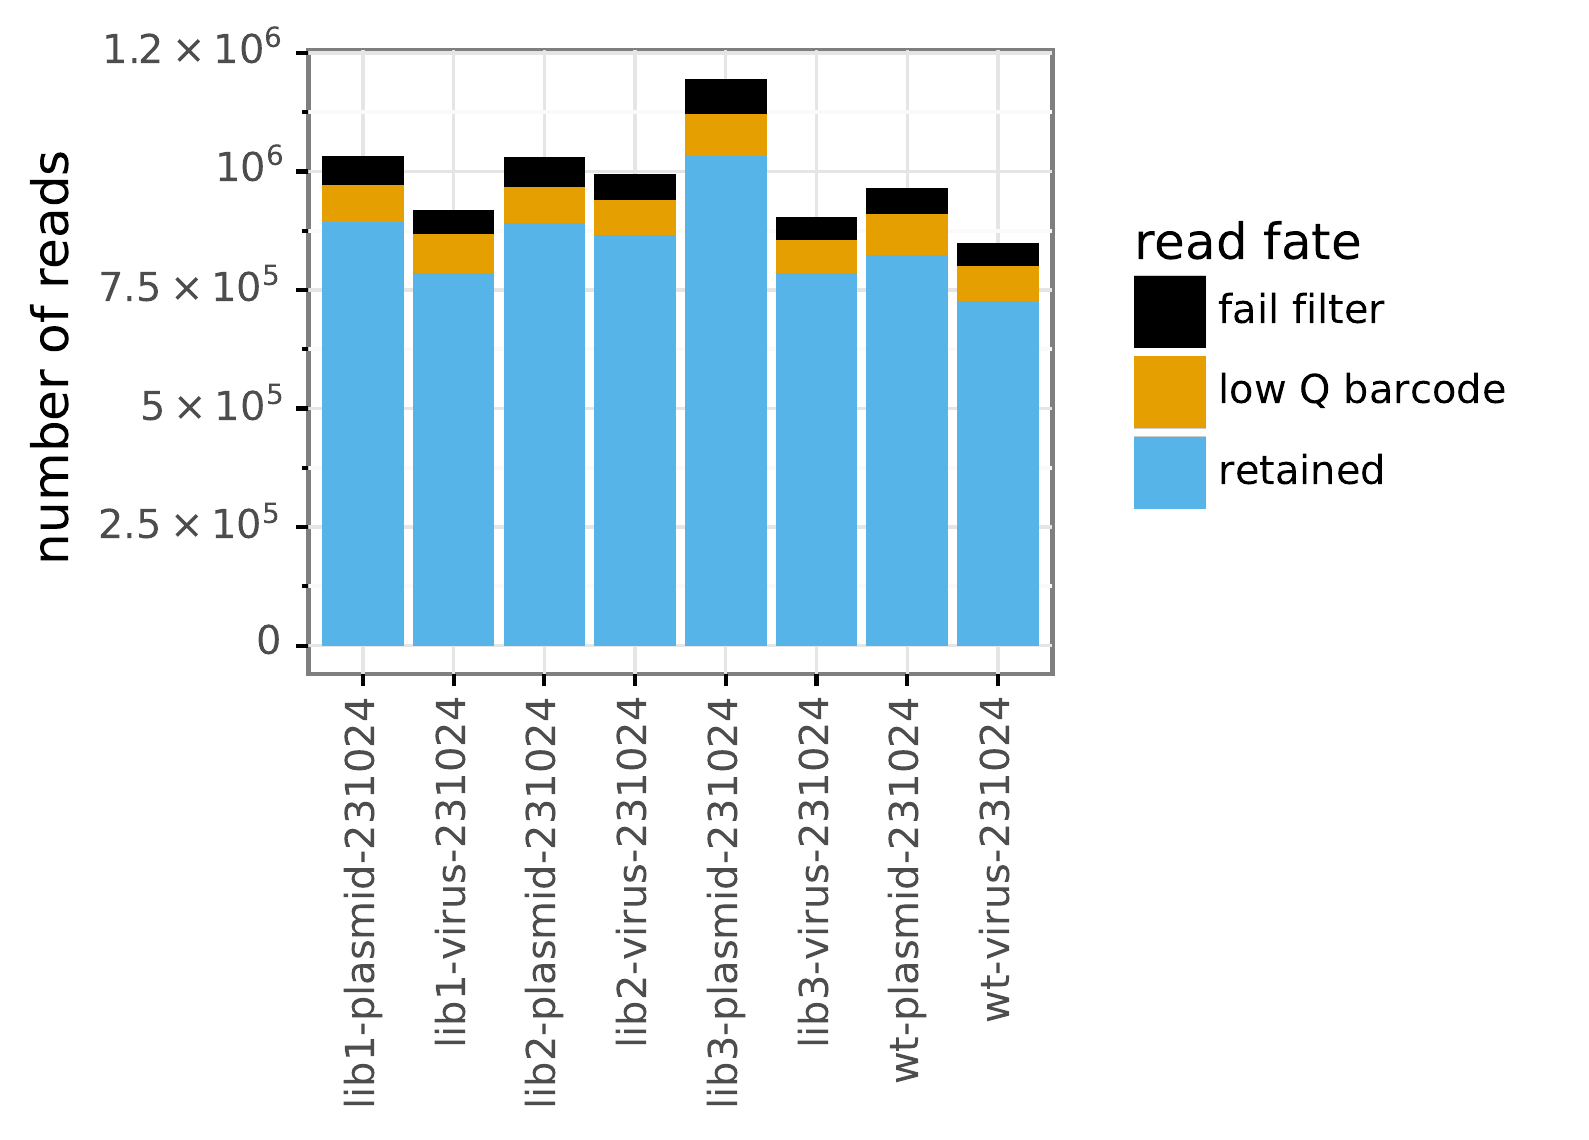

In [10]:
showPDF(bcsubamp_plot_prefix + 'readstats.pdf')

#### Barcode fate

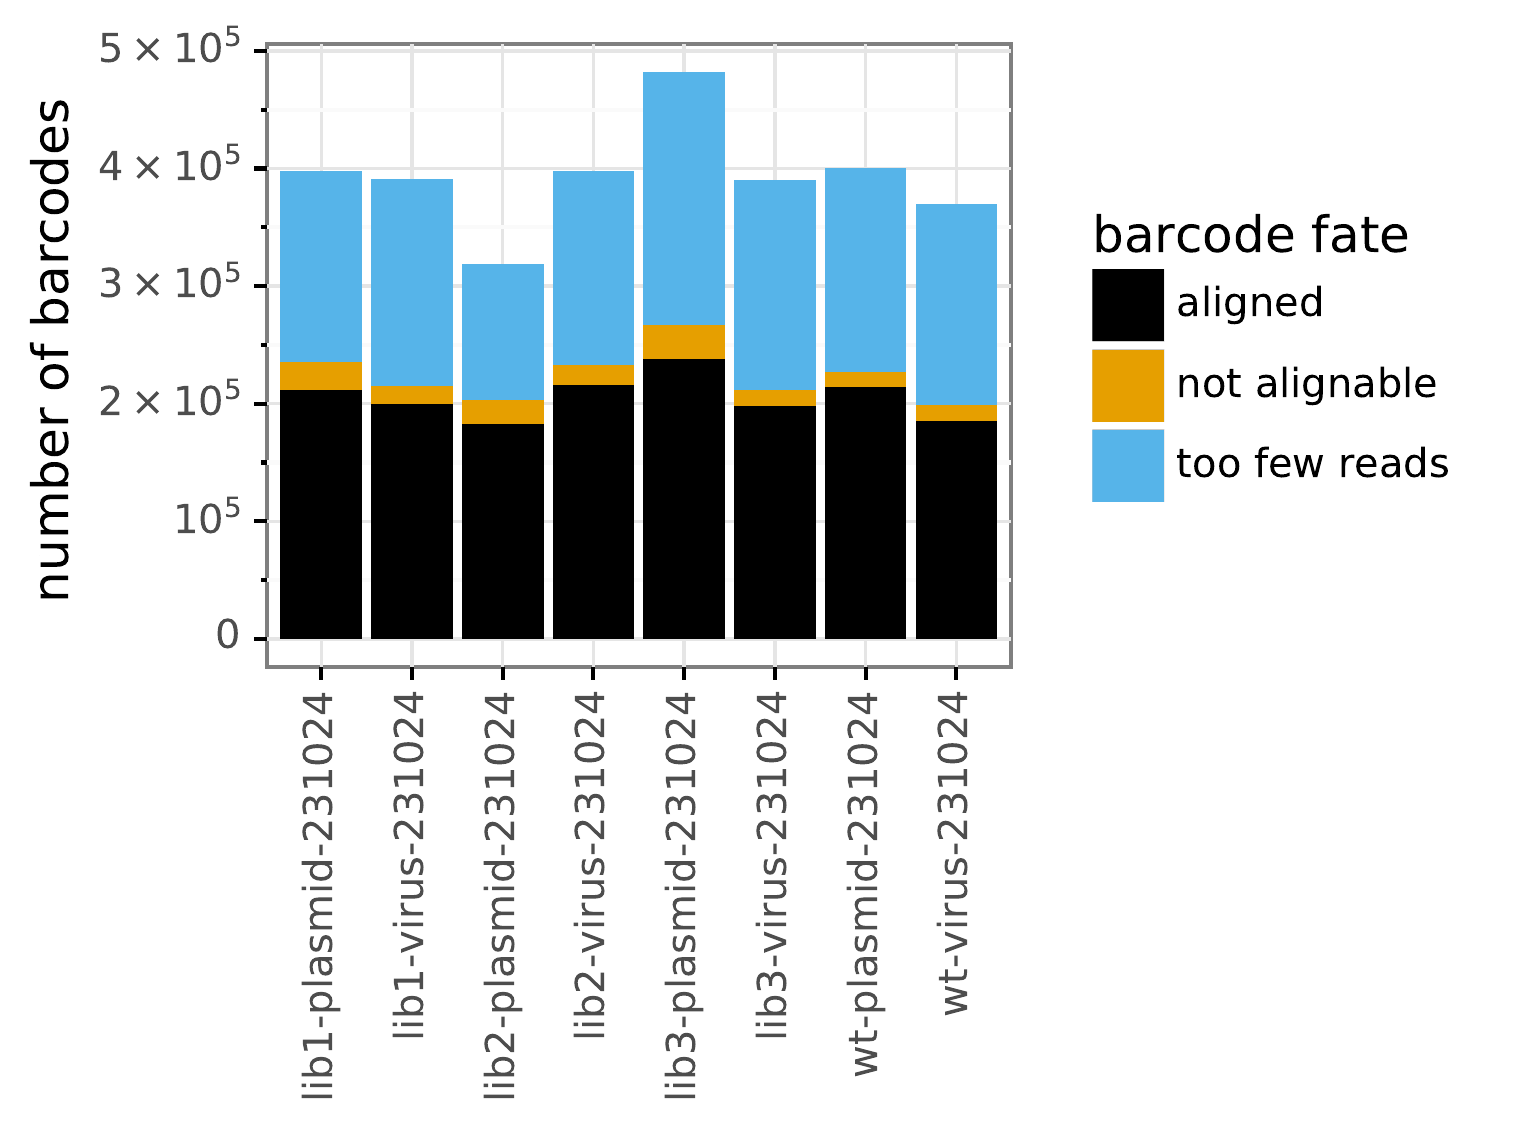

In [11]:
showPDF(bcsubamp_plot_prefix + 'bcstats.pdf')

### Number of reads per barcode

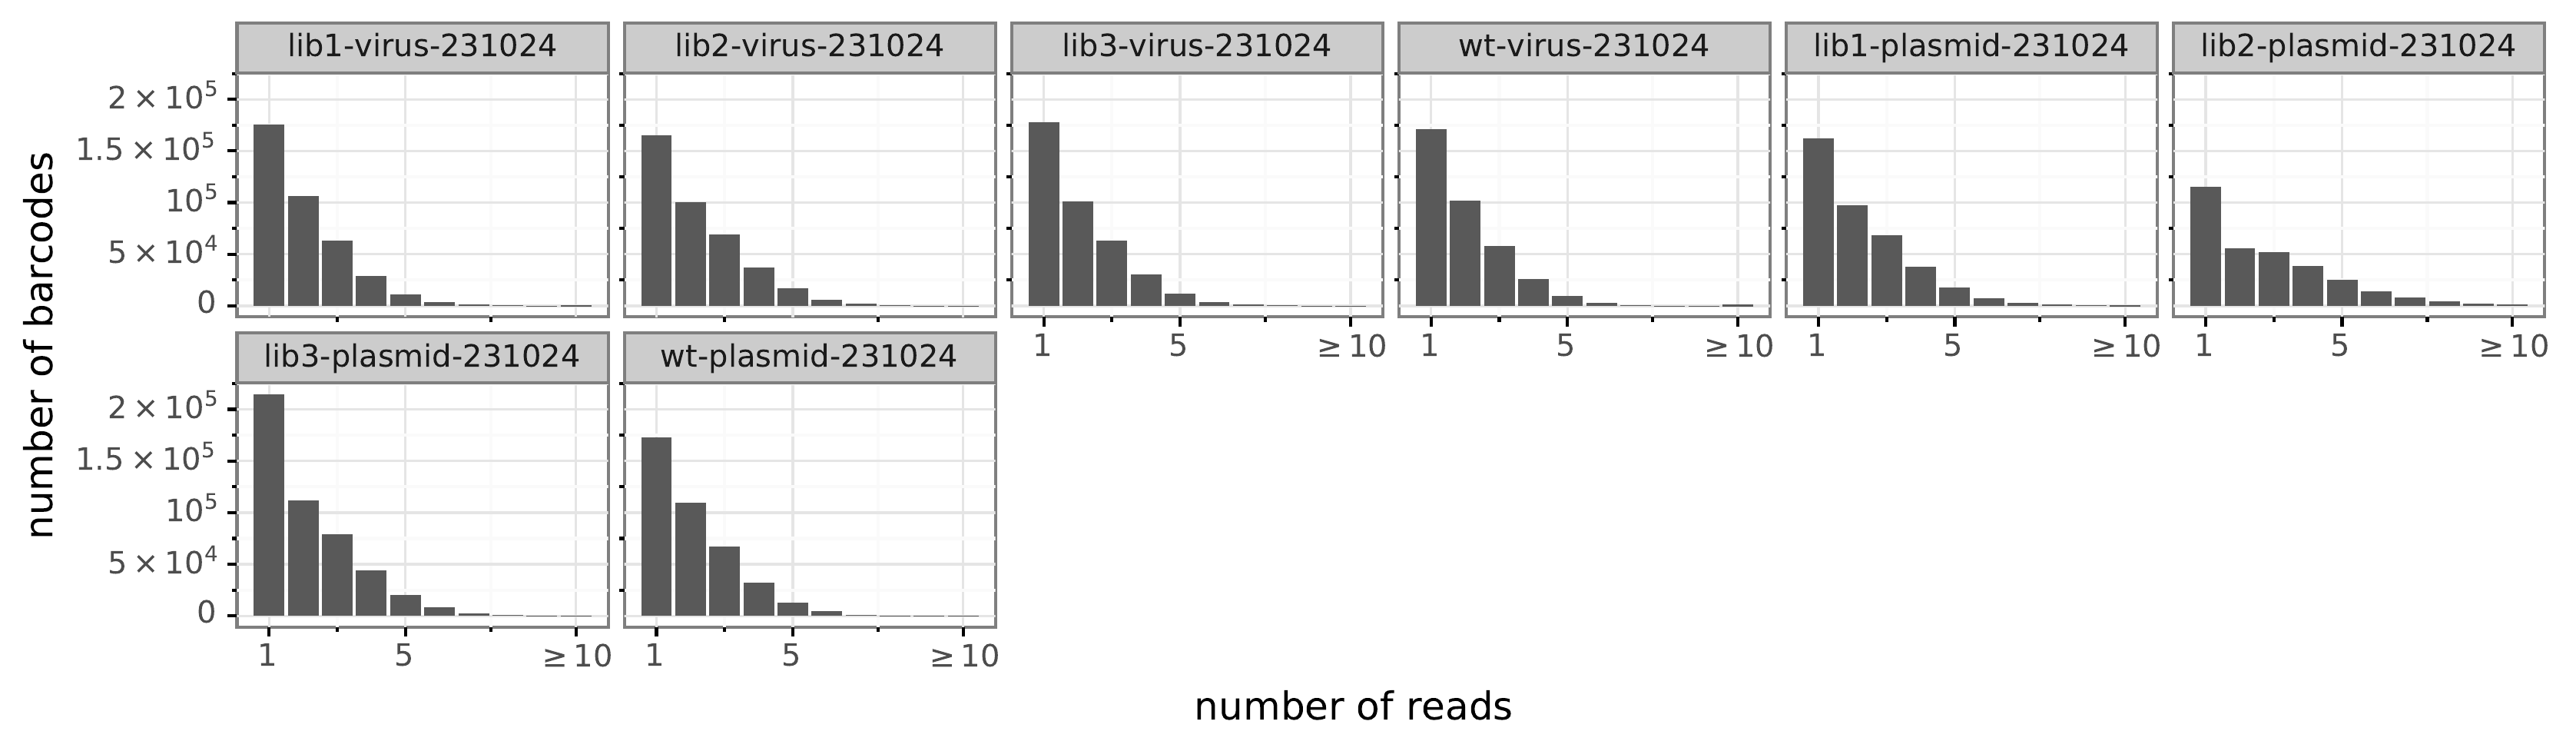

In [12]:
showPDF(bcsubamp_plot_prefix + 'readsperbc.pdf')

### Read depth across the gene

Note that the numbering is with respect to the tile, not the reference.

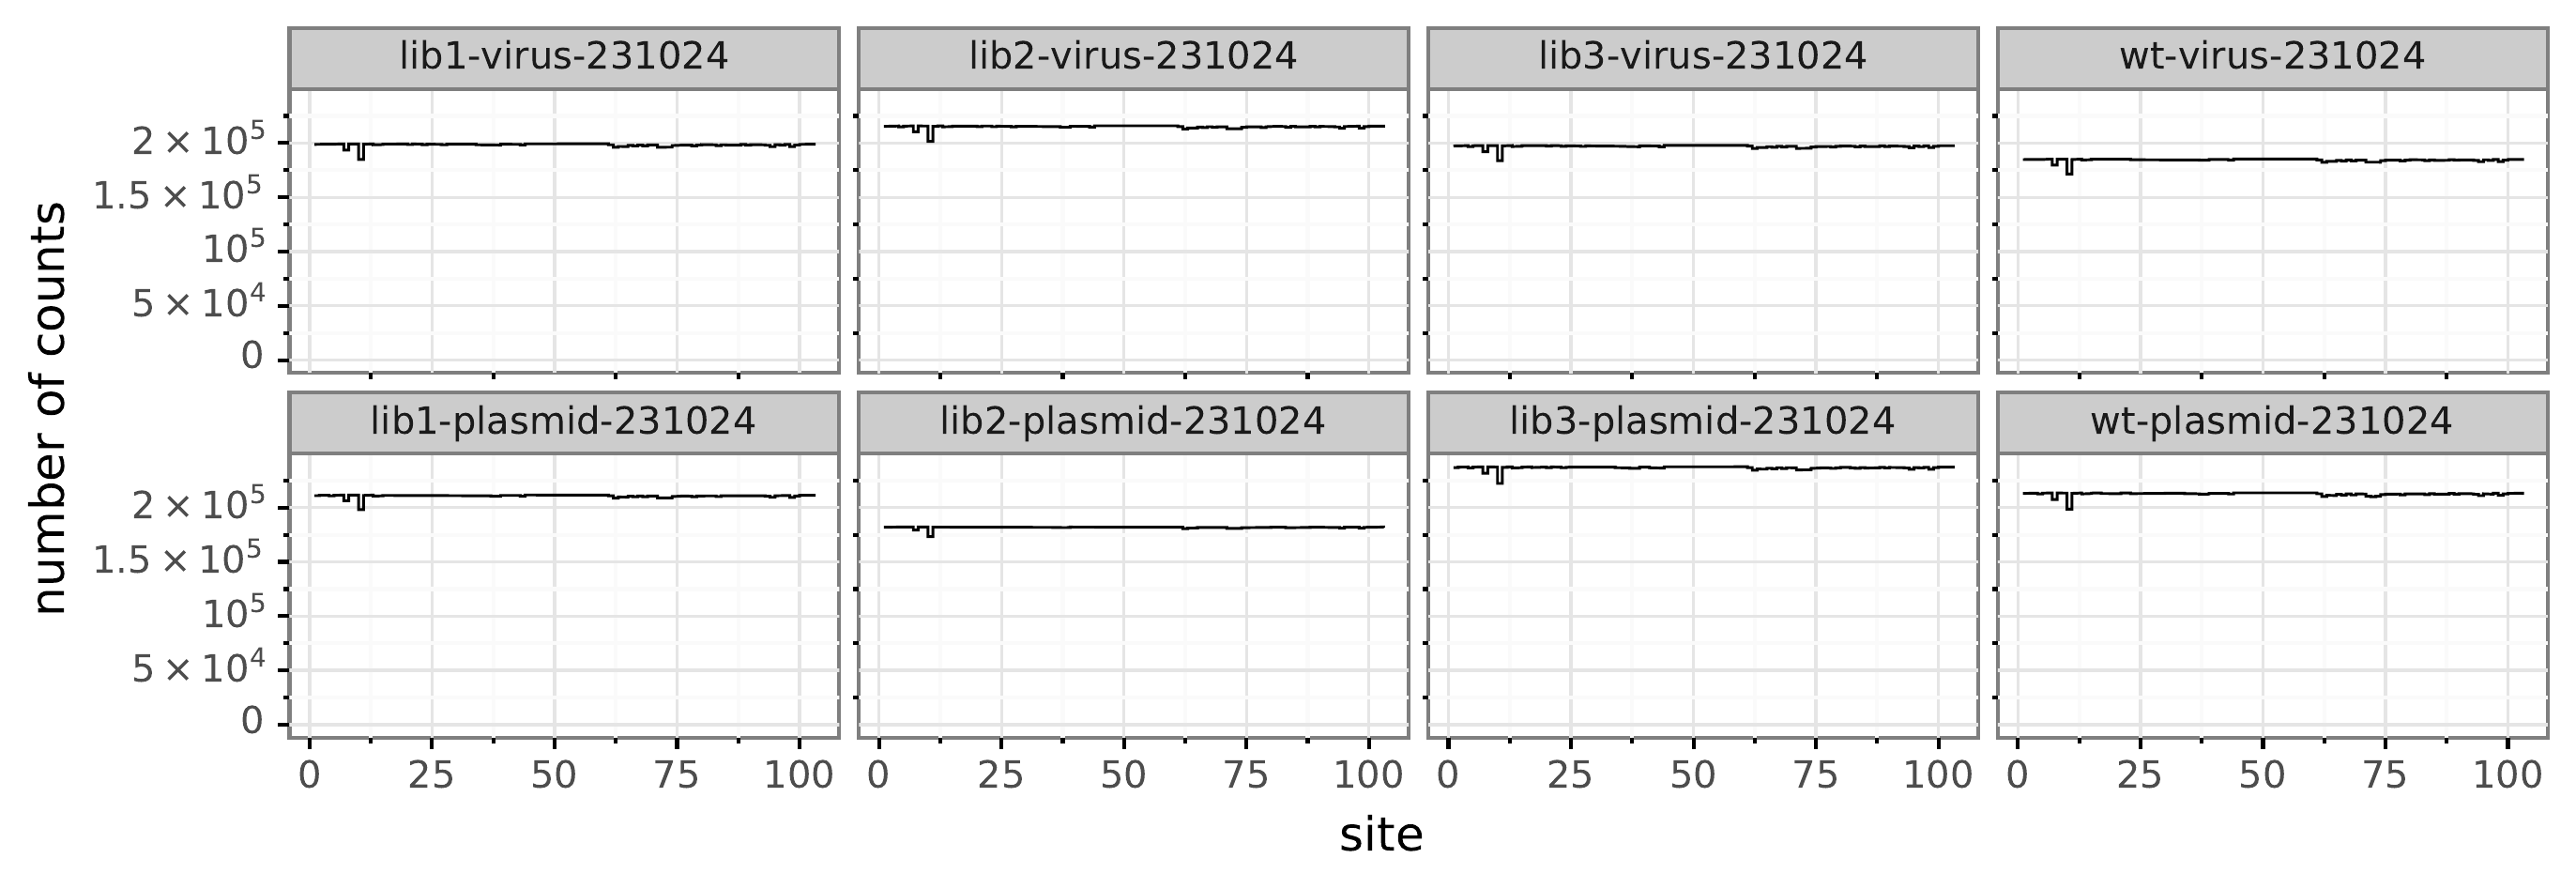

In [13]:
showPDF(bcsubamp_plot_prefix + 'depth.pdf')

### Mutation frequencies across the gene

As expected, the library plasmids have higher mutation rates than the wildtype control.

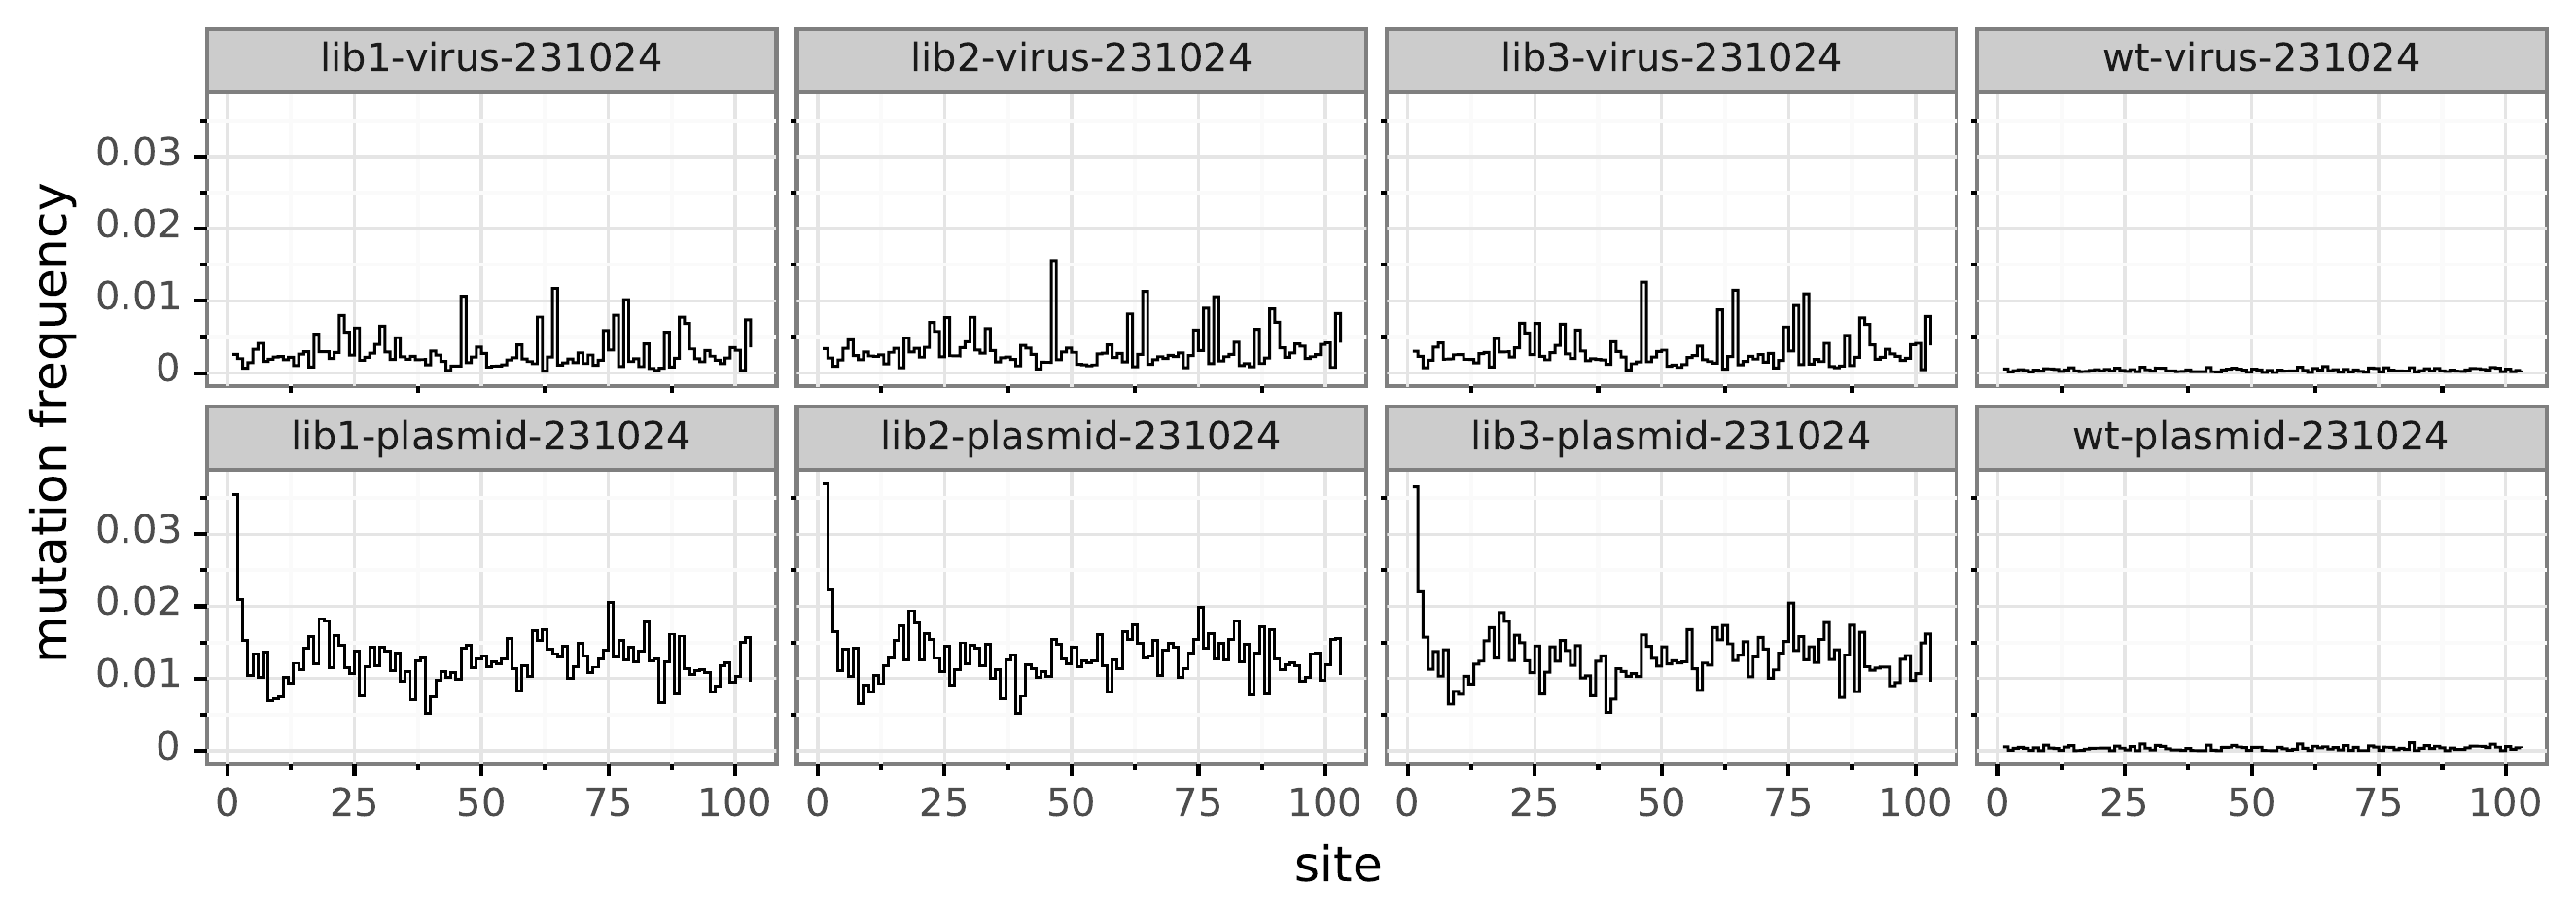

In [14]:
showPDF(bcsubamp_plot_prefix + 'mutfreq.pdf')

### Overall per-codon mutation rate averages

We'd expect that stop mutations and nonsynonymous mutations—most of which are deleterious—are purged after passaging in cell culture.

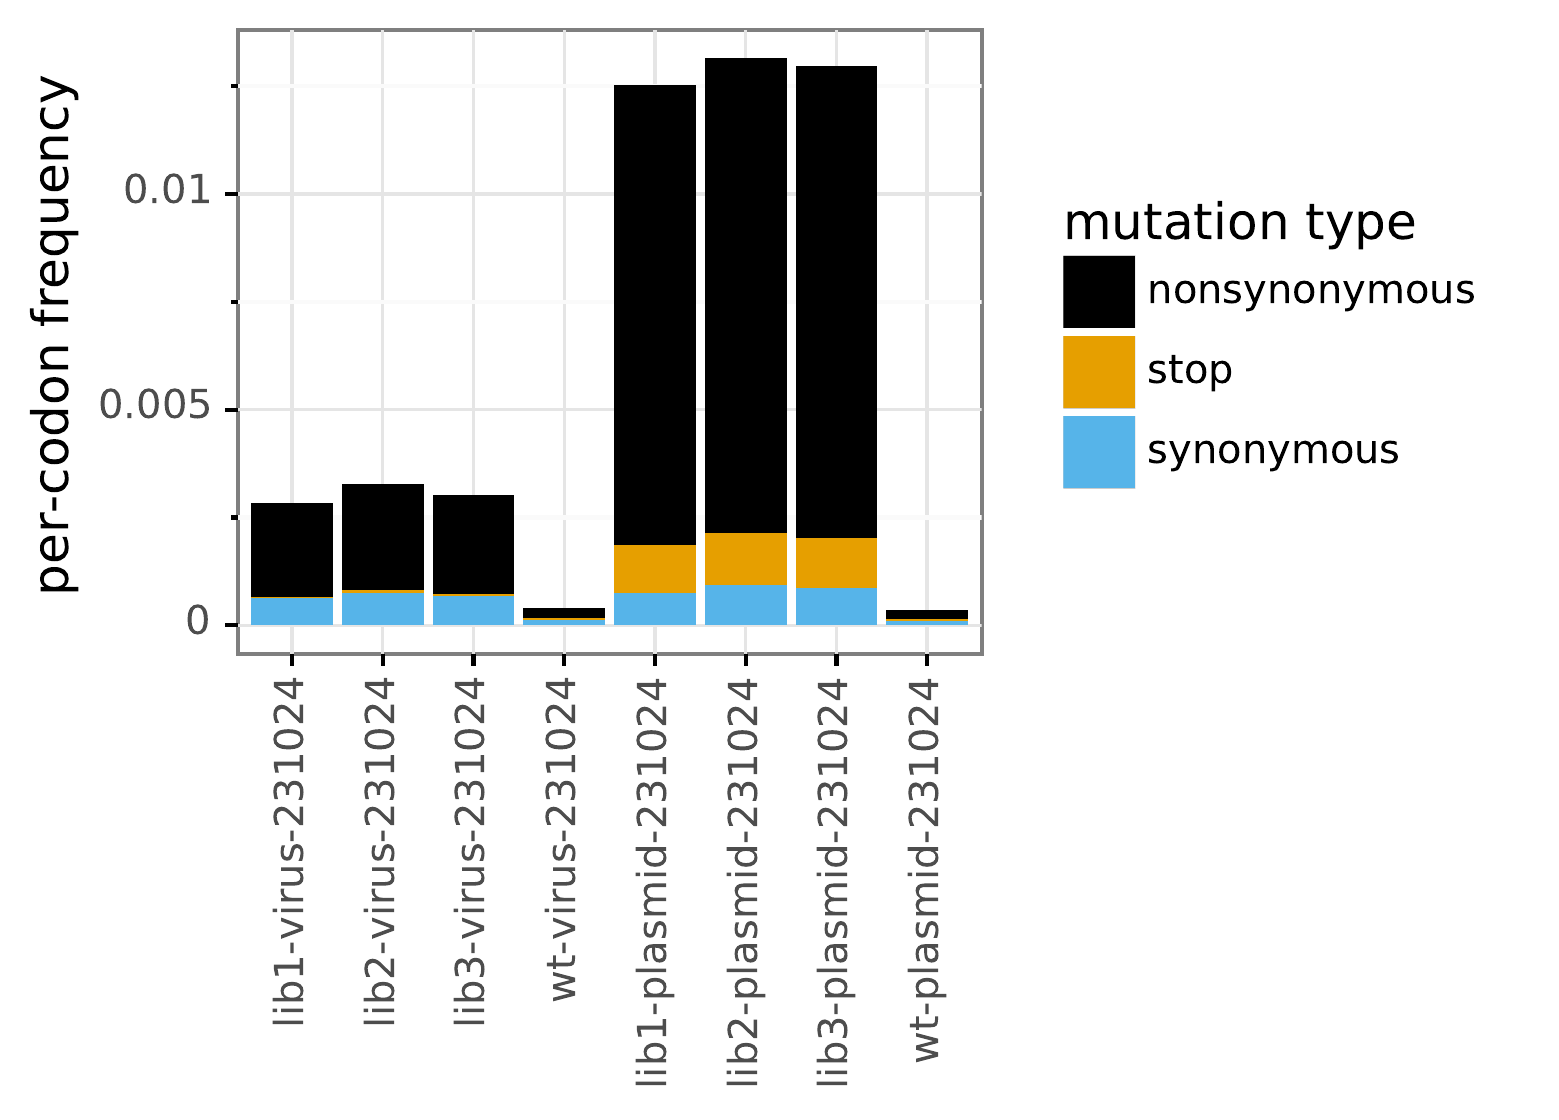

In [15]:
showPDF(bcsubamp_plot_prefix + 'codonmuttypes.pdf')

We have single and multi-nucleotide changes in the libraries, although the single nucleotide changes are perhaps over-represented:

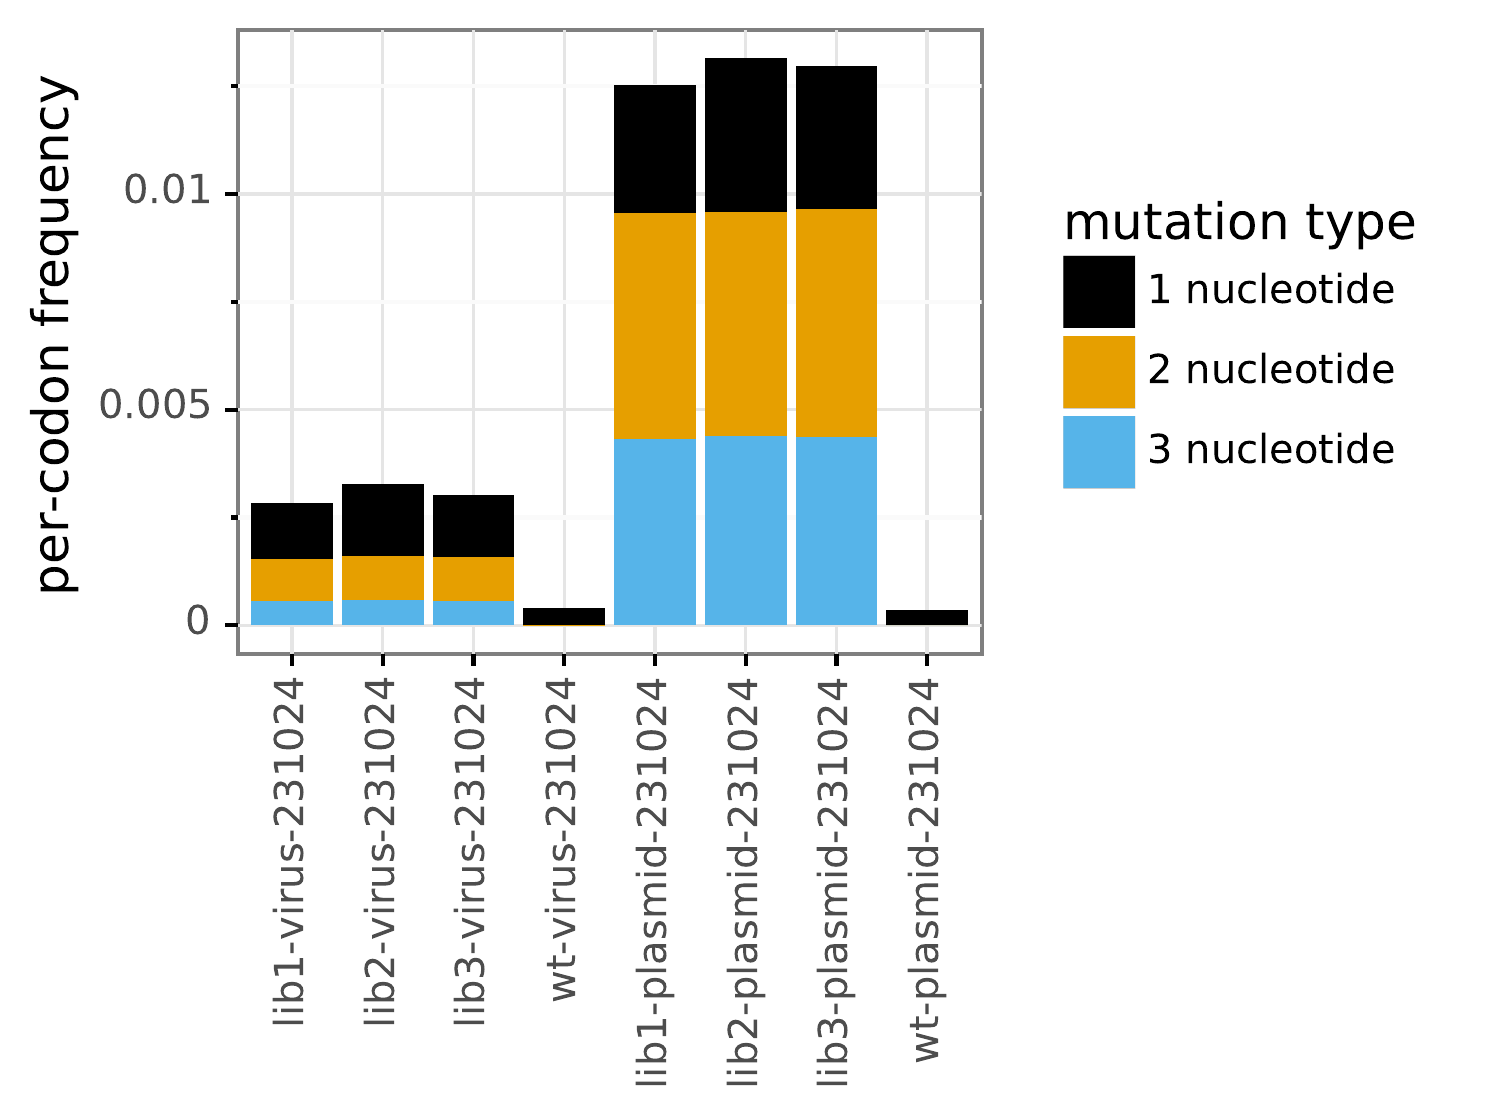

In [16]:
showPDF(bcsubamp_plot_prefix + 'codonntchanges.pdf')

Here are the frequencies of different types of mutations among single-nucleotide codon changes. We are checking for evidence of oxidative damage, which leads to `C->A` or `G->T` mutations:

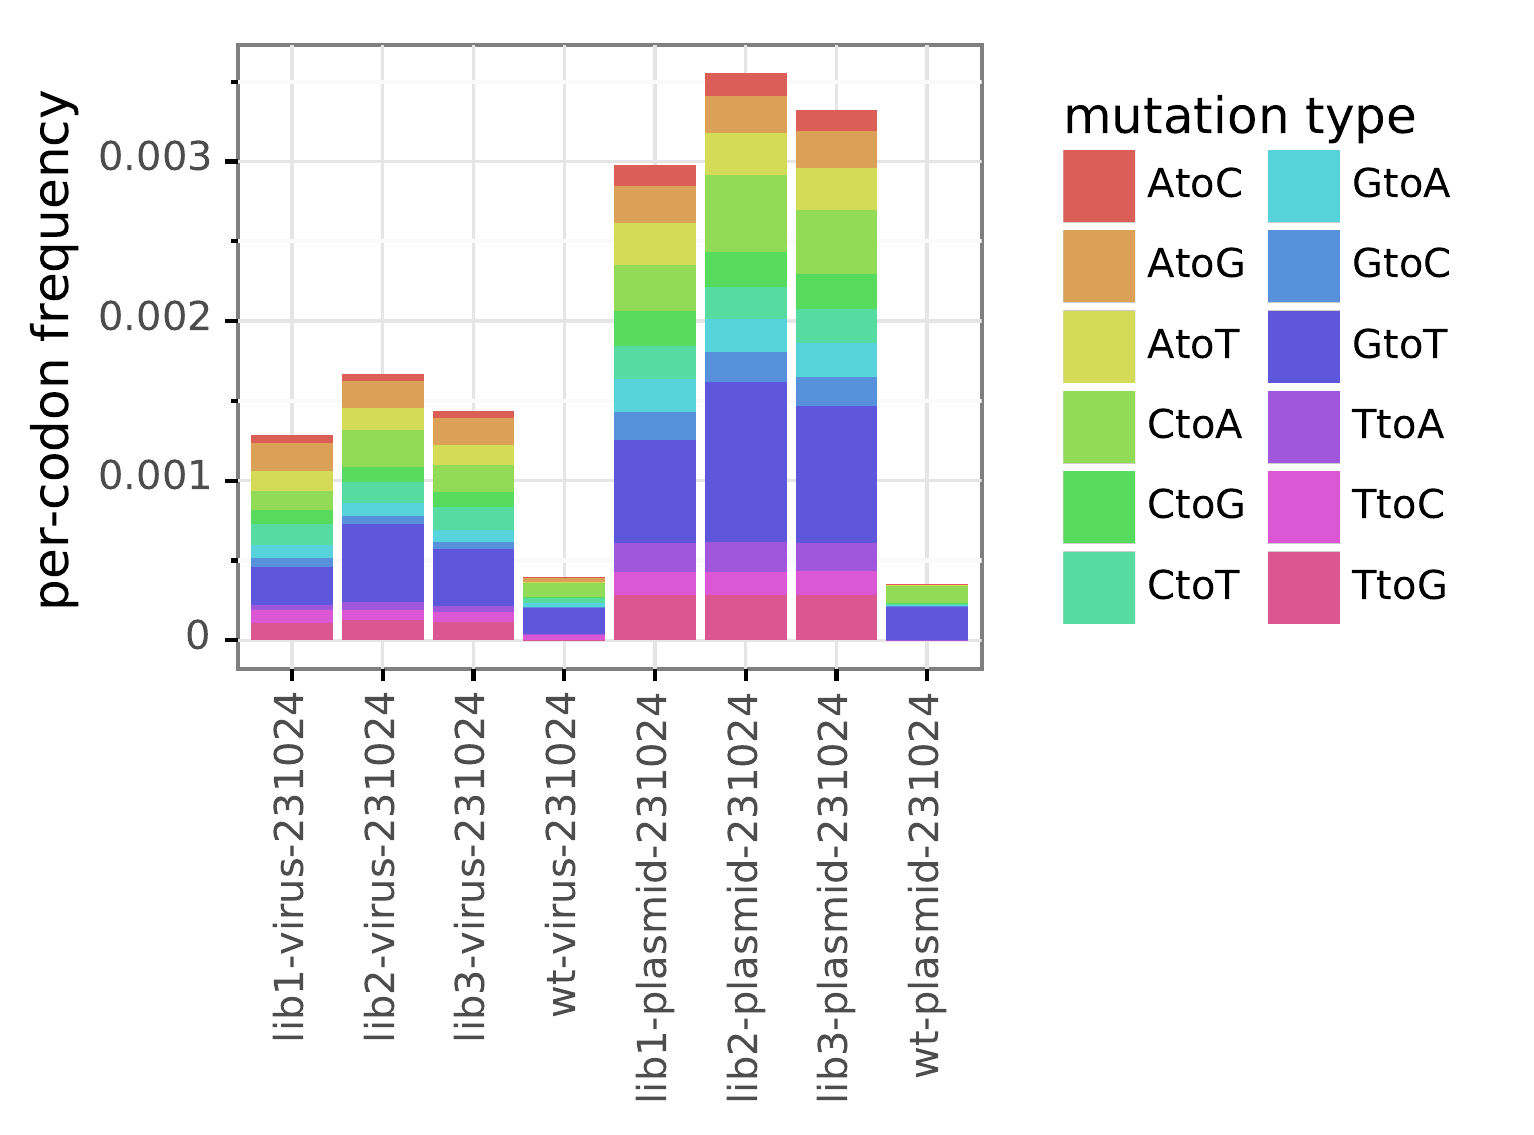

In [17]:
showPDF(bcsubamp_plot_prefix + 'singlentchanges.pdf')

### Mutation sampling

We want to see that most possible mutations are sampled very well in the plasmid samples. We expect that fewer mutations will be sampled after functional selection in virus samples.

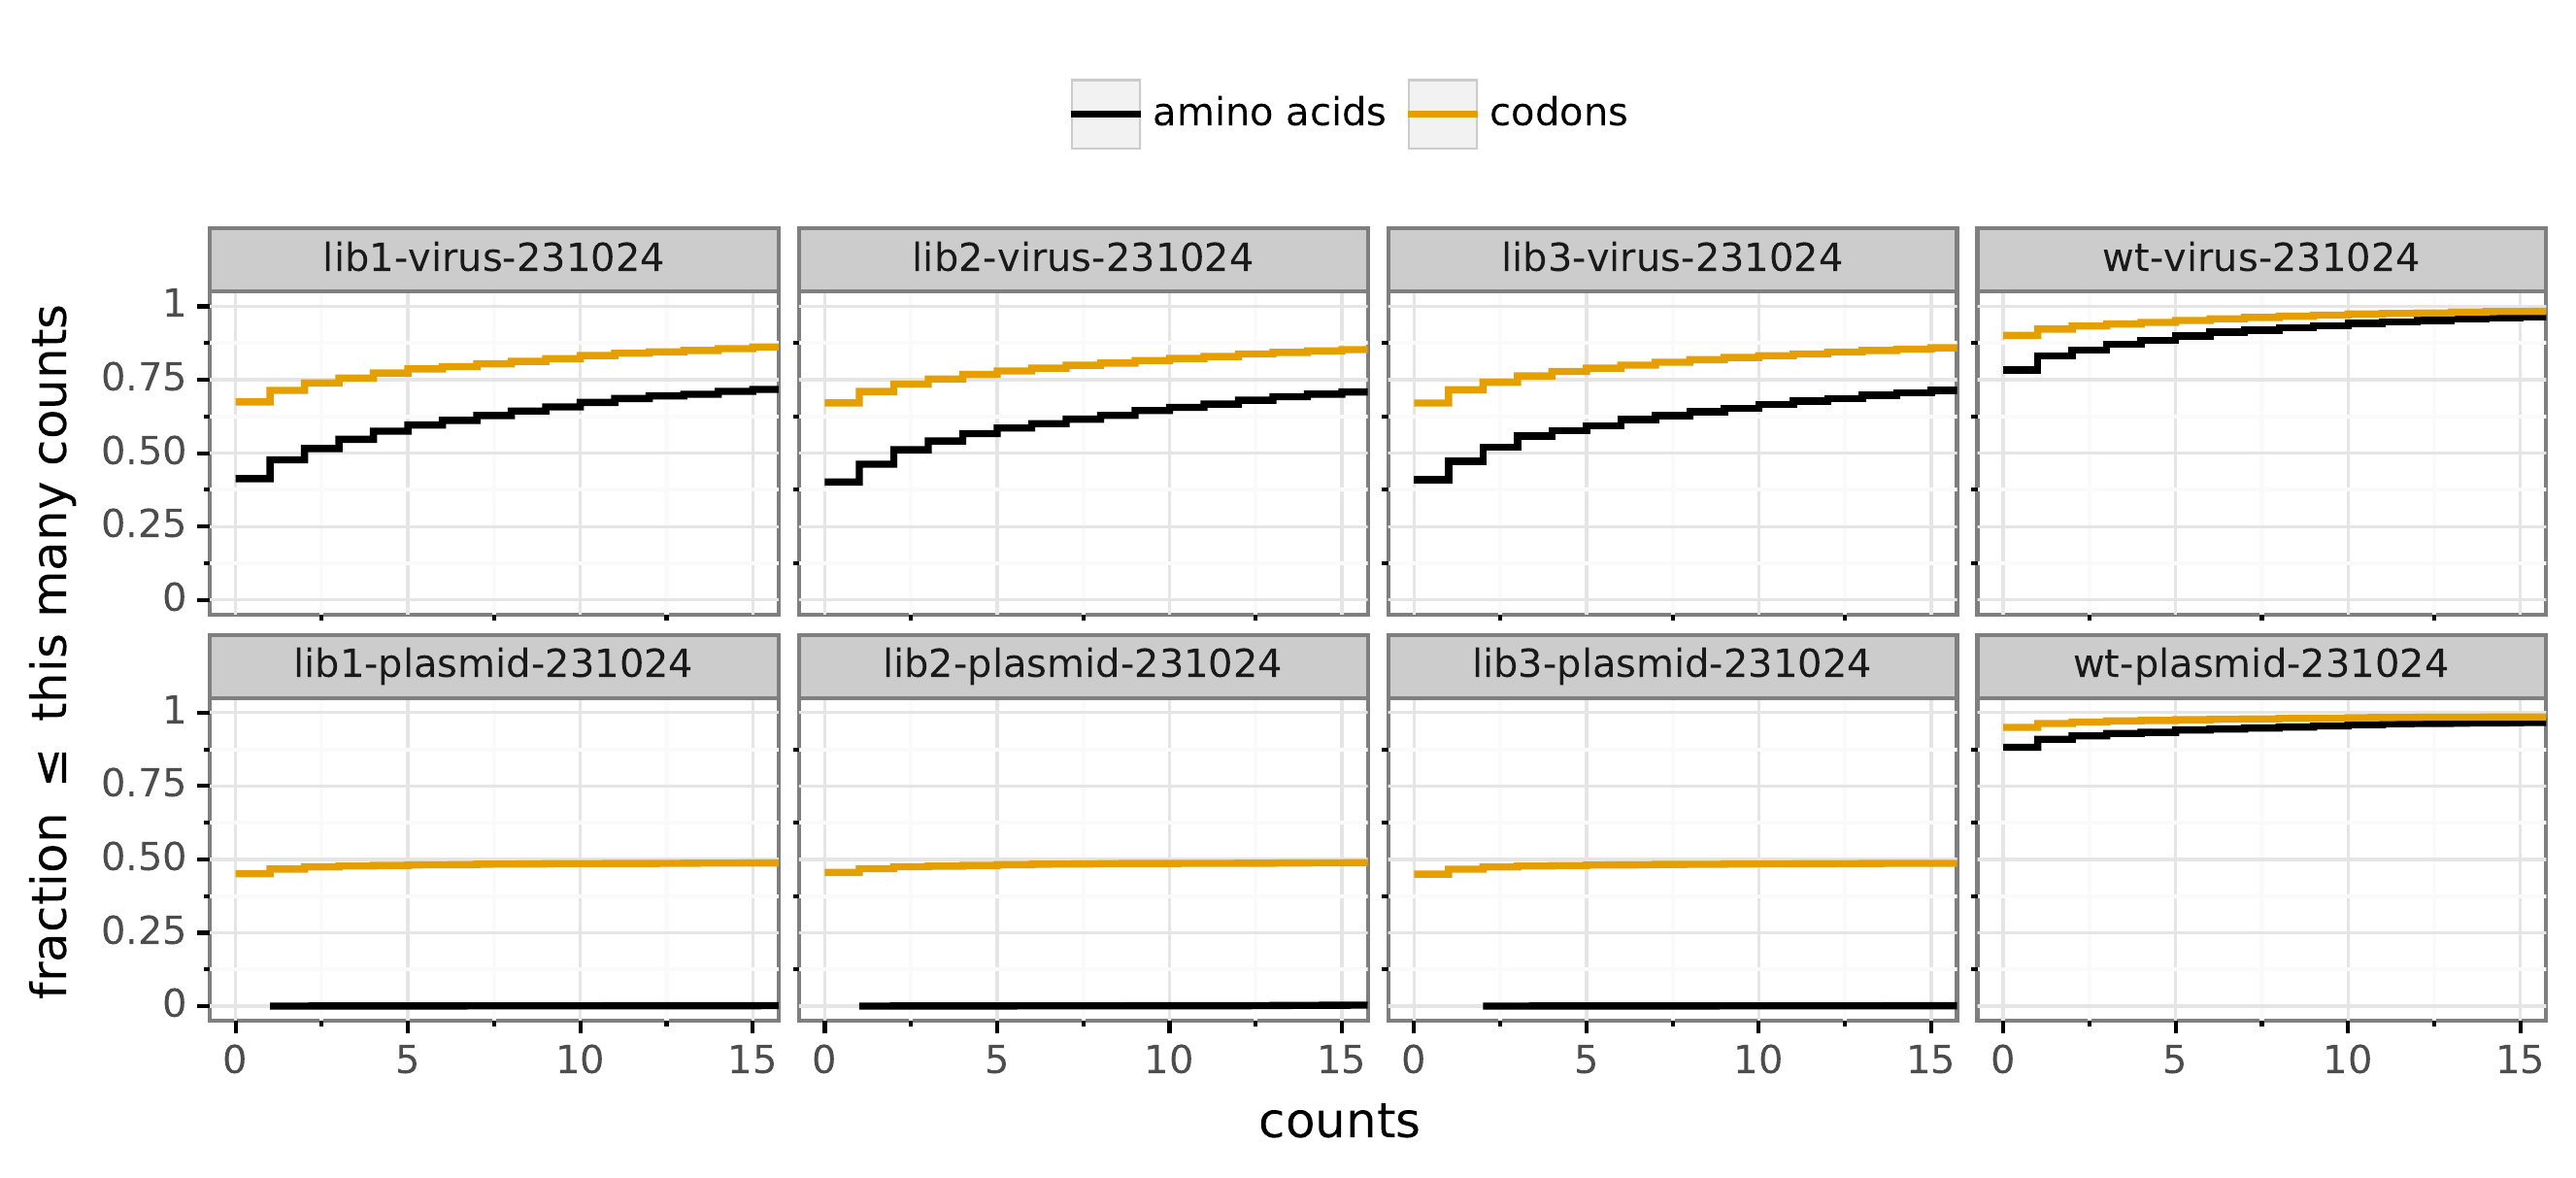

In [18]:
showPDF(bcsubamp_plot_prefix + 'cumulmutcounts.pdf')

## Re-number sites

The data above is numbered with respect to the tile, not the reference genome. Below, we re-number the tile data with respect to the reference gene.


In [19]:
print(f"Renumbering by adding an offset of {site_number_offset}")

Renumbering by adding an offset of 0


Create a directory for the re-numbered codon counts:

In [20]:
renumb_countsdir = os.path.join(resultsdir, 'renumbered_codoncounts')
os.makedirs(renumb_countsdir, exist_ok=True)
print(f"Putting renumbered codon counts in {renumb_countsdir}")

Putting renumbered codon counts in results/tile_1/renumbered_codoncounts


Create a renumbering file:

In [21]:
ncodons = len(refseq)
assert 0 == ncodons % 3, f"invalid {ncodons=}"

renumbfile = os.path.join(renumb_countsdir, 'renumbering.csv')
with open(renumbfile, 'w') as f:
    f.write('original,new\n')
    for orig in range(1, ncodons + 1):
        f.write(f"{orig},{orig + site_number_offset}\n")

Renumber all CSVs:

In [22]:
counts_files = glob.glob(f"{countsdir}/*_codoncounts.csv")
print(f"Renumbering {len(counts_files)} files")

dms_tools2.utils.renumberSites(renumbfile, counts_files, outdir=renumb_countsdir)

Renumbering 8 files


Correct our 'samples' file to include renumb_codoncounts

In [23]:
samples['renumb_codoncounts'] = renumb_countsdir + '/' + samples['name'] + '_codoncounts.csv'

## Functional effects of mutations of viral growth **without** stop codons

We determine the functional effects of mutations on viral growth by comparing the passaged viral variants to the original plasmid library. To do this, we compute the [amino-acid preferences](https://jbloomlab.github.io/dms_tools2/prefs.html#prefs) under selection for viral growth. We do this using [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html).

### Mutation Preference

In [24]:
prefs_batch = (
    samples
    .query('library != "wt"')
    .query('selection != "plasmid"')
    .assign(post=lambda x: x['name'])
    .merge(samples.query('selection == "plasmid"')
                  .assign(pre=lambda x: x['name'])
                  [['library', 'pre']],
           on=['library'], how='left', validate='many_to_one',
           )
    [['name', 'selection', 'library', 'pre', 'post', 'date']]
    .assign(errpre=errpre)
    .merge(samples.query('library == "wt"')
                  .assign(errpost=lambda x: x['name'])
                  [['selection', 'errpost', 'date']],
           on=['selection', 'date'], how='left'
           )
    )
assert prefs_batch.notnull().all().all()

display(prefs_batch)

,name,selection,library,pre,post,date,errpre,errpost
0,lib1-virus-231024,virus,lib1,lib1-plasmid-231024,lib1-virus-231024,231024,wt-plasmid-231024,wt-virus-231024
1,lib2-virus-231024,virus,lib2,lib2-plasmid-231024,lib2-virus-231024,231024,wt-plasmid-231024,wt-virus-231024
2,lib3-virus-231024,virus,lib3,lib3-plasmid-231024,lib3-virus-231024,231024,wt-plasmid-231024,wt-virus-231024


Now run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html):

In [25]:
prefsdir = os.path.join(resultsdir, 'prefs')
os.makedirs(prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {renumb_countsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --method ratio \
        --use_existing {use_existing} \
        --ncpus {ncpus}

assert all(map(os.path.isfile, [os.path.join(prefsdir, name + '_prefs.csv') 
                                for name in prefs_batch.name])), '\n'.join(log)

print("Amino-acid preferences without stop codons calculated for all samples.")


Amino-acid preferences without stop codons calculated for all samples.


Look at correlation among the amino-acid preferences for the individual libraries:

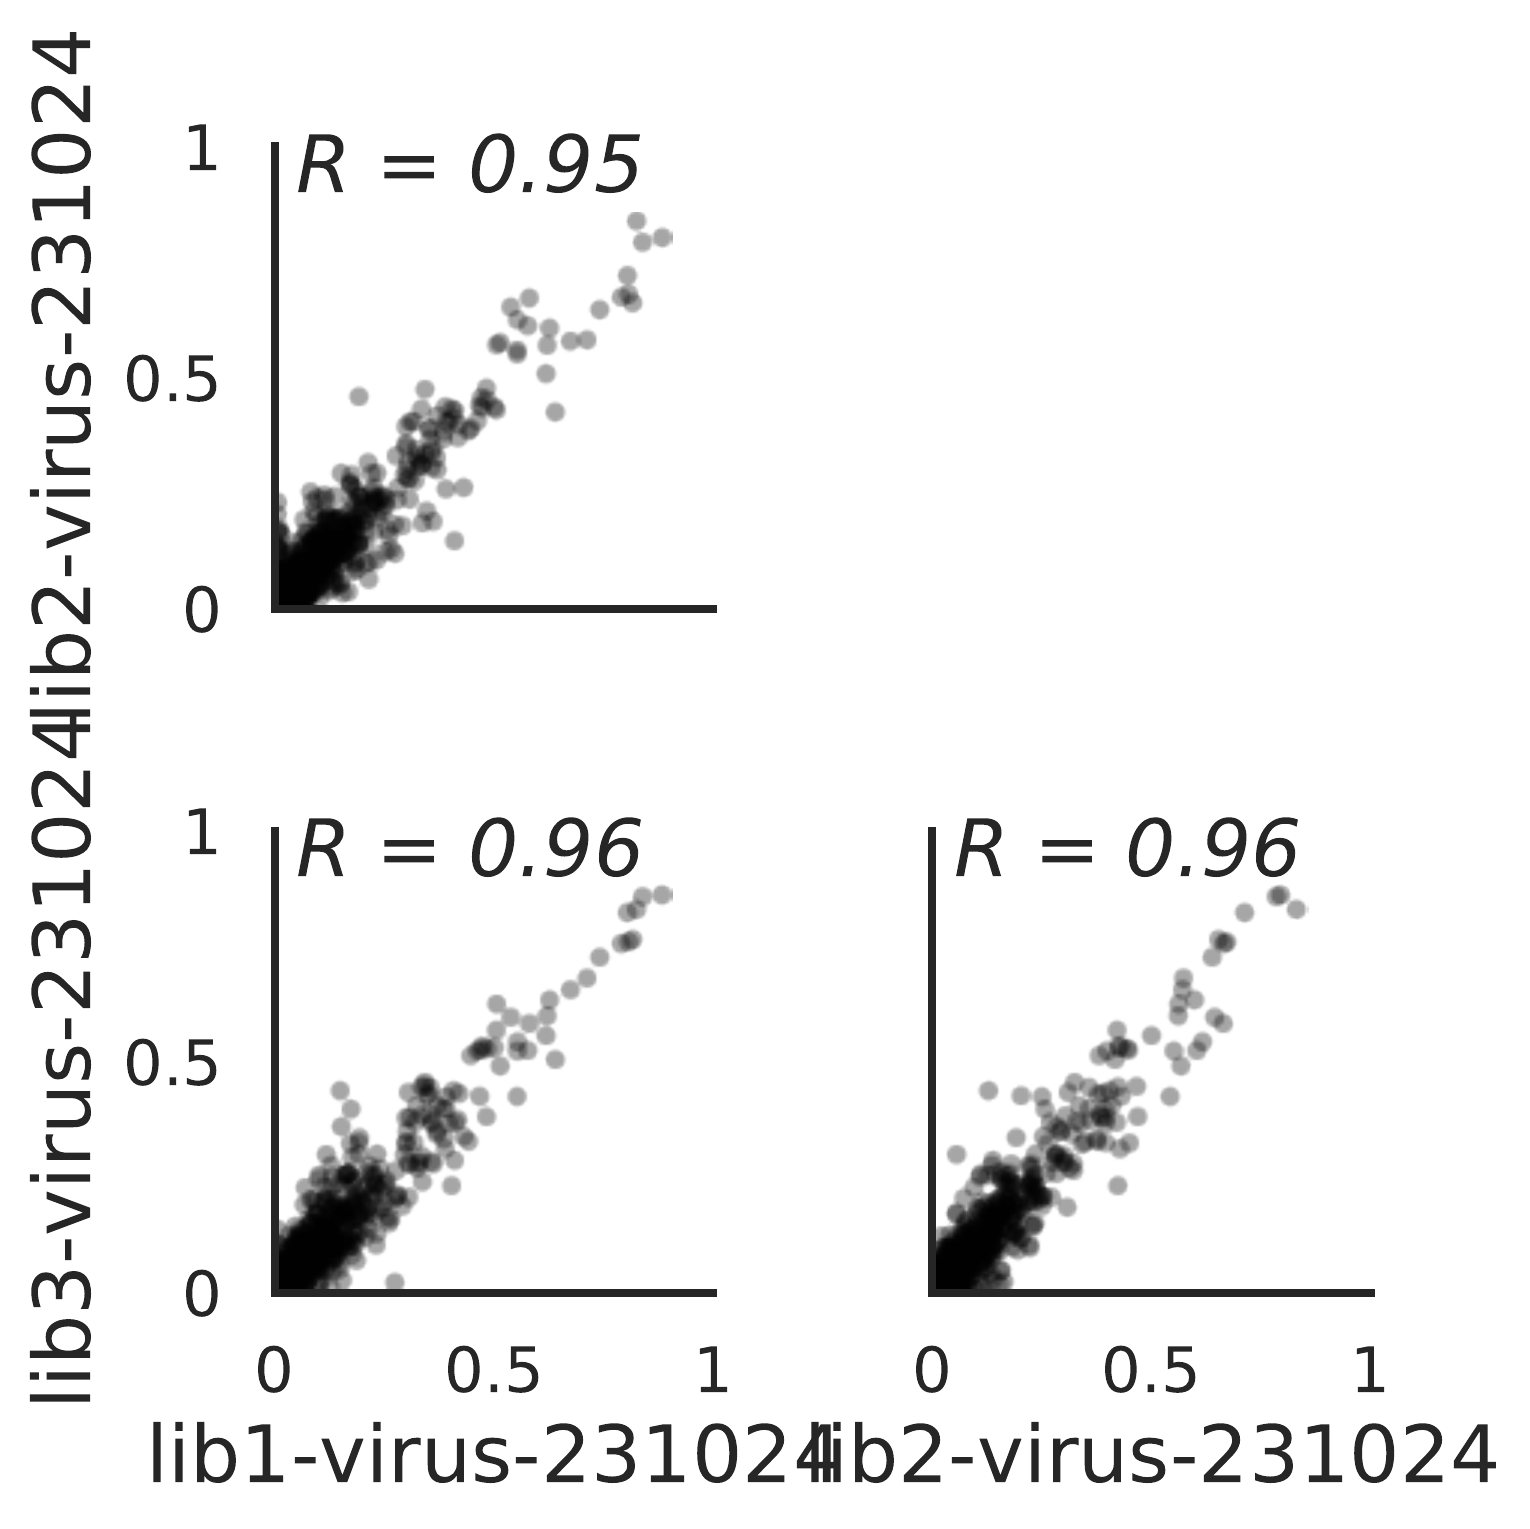

In [26]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'))

Amino-acid preferences for **all** libraries, and for each condition separately (in this case there is only one condition):

In [29]:
# file with preferences for all samples
prefs_files = {}
for selection, df in prefs_batch.groupby('selection'):
    selection_prefsfiles = [os.path.join(prefsdir, f"{name}_prefs.csv") for name in df['name']]
    assert all(map(os.path.isfile, selection_prefsfiles)), selection_prefsfiles
    prefs_files[selection] = os.path.join(prefsdir, f"prefs_{selection}.csv")
    dms_tools2.prefs.avgPrefs(selection_prefsfiles).to_csv(prefs_files[selection],
                                                           index=False,
                                                           float_format='%.5f')
    
print('Average preferences across conditions are in the following files:')
display(HTML(pd.Series(prefs_files).rename('file').to_frame().to_html()))

                name selection library                  pre  \
0  lib1-virus-231024     virus    lib1  lib1-plasmid-231024   
1  lib2-virus-231024     virus    lib2  lib2-plasmid-231024   
2  lib3-virus-231024     virus    lib3  lib3-plasmid-231024   

                post    date             errpre          errpost  
0  lib1-virus-231024  231024  wt-plasmid-231024  wt-virus-231024  
1  lib2-virus-231024  231024  wt-plasmid-231024  wt-virus-231024  
2  lib3-virus-231024  231024  wt-plasmid-231024  wt-virus-231024  
Average preferences across conditions are in the following files:


,file
virus,results/tile_1/prefs/prefs_virus.csv


Now we will make a logo plot of the average of the amino-acid preferences across all samples, and each group of samples.
We do this using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html). Note that this logo plot shows the raw unscaled (not re-scaled) preferences. In this plot, the height of each letter is proportional to the "preference" for that amino acid at that site, so taller letters are more preferred at a site. If the site tolerates everything, there will just be lots of small letters as all amino acids equally tolerated:

In [ ]:
logodir = os.path.join(resultsdir, 'logoplots')
os.makedirs(logodir, exist_ok=True)

# get wildtype amino acids to use as overlay
wt_aas = pd.DataFrame.from_records(
            [(r + 1 + site_number_offset, a) for r, a in enumerate(refprot) if a != '*'],
            columns=['site', 'wildtype'])
wtoverlayfile = os.path.join(logodir, 'wt_overlay.csv')
wt_aas.to_csv(wtoverlayfile, index=False)

for selection, prefs_csv in prefs_files.items():

    logoplot = os.path.join(logodir, f"{selection}_prefs.pdf")

    log = ! dms2_logoplot \
            --prefs {prefs_csv} \
            --name {selection} \
            --outdir {logodir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --letterheight 1.2 \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nPreferences for {selection} samples:")
    showPDF(logoplot)


### Mutation Effect

We can also represent the effects of mutations as the ratio of the preference for the mutant amino-acid to the wildtype amino-acid. This is a measure of its enrichment. If we take the log of this mutational effect, negative values indicate deleterious mutations and positive values indicate favorable mutations. The potential advantage of this representation is that it better shows the detailed differences between mutations to amino acids with small preferences, which can be useful for figuring out if we think a mutation is just very mildly deleterious or highly deleterious.

In [ ]:
muteffectsdir = os.path.join(resultsdir, 'muteffects')
os.makedirs(muteffectsdir, exist_ok=True)

We convert the amino-acid preferences into mutational effects without stop codons. Then, we make a logo plots showing the mutational effects for all samples, and for each condition. Letters below the line indicate deleterious mutations, and letters above the line indicate beneficial ones. We include a scale bar indicating the fold-enrichment implied by each letter height. 

In [ ]:
# ensure stop codons are not in the character list
if '*' in AAS:
    AAS.remove('*')

# calculate mutational effects 
muteffects_files = {}
for selection, prefs_csv in prefs_files.items():
    muteffects = dms_tools2.prefs.prefsToMutFromWtEffects(
                    prefs=pd.read_csv(prefs_csv),
                    charlist=AAS,
                    wts=wt_aas)
    muteffects_files[selection] = os.path.join(muteffectsdir, f"{selection}_muteffects.csv")
    print(f"Writing mutational effects for {selection} to {muteffects_files[selection]}")
    muteffects.to_csv(muteffects_files[selection], index=False, float_format='%.5g')

for selection, muteffects_csv in muteffects_files.items():

    logoplot = os.path.join(logodir, f"{selection}_muteffects.pdf")

    log = ! dms2_logoplot \
            --muteffects {muteffects_csv} \
            --name {selection} \
            --outdir {logodir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --scalebar 6.64 "100-fold change (log scale)" \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nMutational effects for {selection} samples:")
    showPDF(logoplot)

## Functional effects of mutations of viral growth **with** stop codons

Going back to the amino acid preferences step, run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html) again, this time including stop codons. 

In [ ]:
prefs_withStops_dir = os.path.join(resultsdir, 'prefs_withStops')
os.makedirs(prefs_withStops_dir, exist_ok=True)

log = ! dms2_batch_prefs \
        --indir {renumb_countsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefs_withStops_dir} \
        --summaryprefix summary \
        --method ratio \
        --excludestop 'no' \
        --use_existing {use_existing} \
        --ncpus {ncpus}

assert all(map(os.path.isfile, [os.path.join(prefsdir, name + '_prefs.csv') 
                                for name in prefs_batch.name])), '\n'.join(log)

print("Amino-acid preferences with stop codons calculated for all samples.")

Now let's get the amino-acid preferences for **all** samples, and for each condition separately:

In [ ]:
prefs_withStops_files = {}

# file with preferences for each condition
for selection, df in prefs_batch.groupby('selection'):
    selection_prefsfiles = [os.path.join(prefs_withStops_dir, f"{name}_prefs.csv") for name in df['name']]
    assert all(map(os.path.isfile, selection_prefsfiles)), selection_prefsfiles
    prefs_withStops_files[selection] = os.path.join(prefs_withStops_dir, f"prefs_{selection}.csv")
    dms_tools2.prefs.avgPrefs(selection_prefsfiles).to_csv(prefs_withStops_files[selection],
                                                           index=False,
                                                           float_format='%.5f')
    
print('Average preferences across conditions are in the following files:')
display(HTML(pd.Series(prefs_withStops_files).rename('file').to_frame().to_html()))

Output logoplots of amino acid preferences with stop codons.

In [ ]:
logo_withStops_dir = os.path.join(resultsdir, 'logoplots_withStops')
os.makedirs(logo_withStops_dir, exist_ok=True)

for selection, prefs_csv in prefs_withStops_files.items():

    logoplot = os.path.join(logo_withStops_dir, f"{selection}_prefs.pdf")

    log = ! dms2_logoplot \
            --prefs {prefs_csv} \
            --name {selection} \
            --outdir {logo_withStops_dir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --letterheight 1.2 \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nPreferences for {selection} samples:")
    showPDF(logoplot)


Repeat converting the amino-acid preferences into mutational effects, now including stop codons. Then make logo plots as above.

In [ ]:
# Analysis inlcuding stop codons, as means of validating expected deleterious effects
muteffects_withStops_dir = os.path.join(resultsdir, 'muteffects_withStops')
os.makedirs(muteffects_withStops_dir, exist_ok=True)

# Add stop codon to character list
if '*' not in AAS:
    AAS.append('*')

# Calculate mutational effects 
muteffects_withStops_files = {}
for selection, prefs_withStops_csv in prefs_withStops_files.items():
    muteffects_withStops = dms_tools2.prefs.prefsToMutFromWtEffects(
                    prefs=pd.read_csv(prefs_withStops_csv),
                    charlist=AAS,
                    wts=wt_aas)
    muteffects_withStops_files[selection] = os.path.join(muteffects_withStops_dir, f"{selection}_muteffects.csv")
    print(f"Writing mutational effects for {selection} to {muteffects_withStops_files[selection]}")
    muteffects_withStops.to_csv(muteffects_withStops_files[selection], index=False, float_format='%.5g')

for selection, muteffects_withStops_csv in muteffects_withStops_files.items():

    logoplot = os.path.join(logo_withStops_dir, f"{selection}_muteffects.pdf")

    log = ! dms2_logoplot \
            --muteffects {muteffects_withStops_csv} \
            --name {selection} \
            --outdir {logo_withStops_dir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --scalebar 6.64 "100-fold change (log scale)" \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nMutational effects for {selection} samples:")
    showPDF(logoplot)